# Régression CatBoost

## Cloner la branche contenant le dataset et le code qui va avec.

In [57]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 868, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 868 (delta 71), reused 110 (delta 40), pack-reused 717
Receiving objects: 100% (868/868), 123.29 MiB | 35.66 MiB/s, done.
Resolving deltas: 100% (361/361), done.
total 96
drwxr-xr-x 2 root root  4096 Oct 26 09:14 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root  4096 Oct 26 09:14 AllstateClaimsSeverity/
drwxr-xr-x 2 root root  4096 Oct 26 09:14 Data/
drwxr-xr-x 2 root root  4096 Oct 26 09:14 EMTboost/
drwxr-xr-x 2 root root  4096 Oct 26 09:14 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root  4096 Oct 26 09:14 Models/
-rw-r--r-- 1 root root    54 Oct 26 09:14 README.md
drwxr-xr-x 2 root root  4096 Oct 26 09:14 Plots/
drwxr-xr-x 2 root root  4096 Oct 26 09:14 Notebooks/
drwxr-xr-x 2 root root  4096 Oct 26 09:14 src/
-rw-r--r-- 1 root root 19545 Oct 26 09:14 myXGBoostRegressor.ipynb
-r

In [58]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

total 0


In [59]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [60]:
import installHelper

In [61]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 221 ms, sys: 33.1 ms, total: 254 ms
Wall time: 48.9 s


In [62]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [63]:
# Importer les packages nécéssaires
from helper import *

In [64]:
# Appliquer le theme par défaut
#sns.set_theme()

## Partir du dataset déjà encodé.

In [65]:
# Partir du dataset déja encodé.
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [66]:
X = df.drop('CHARGE', axis=1)
y = df['CHARGE']

Tout d'abord, nous séparons la cible du cadre de données avec des caractéristiques (df -> X, y).

Ensuite, nous divisons les données en ensembles train/val/test dans le rapport 60:20:20. L'idée est que nous utiliserons l'ensemble train pour entraîner nos modèles, l'ensemble val pour les valider et l'ensemble test pour calculer l'erreur finale du mélange. L'ensemble de test sera donc constitué de données totalement inédites.

Pour ce faire, utilisez un train_test_split régulier de sklearn pour diviser X et y en parties train et val/test dans le ratio 60:40. Ensuite, utilisez à nouveau train_test_split, mais pour diviser la partie val/test obtenue en validation et test dans un rapport 50:50. Dans chaque application de train_test_split, utilisez random_state=13 et les autres valeurs de paramètres par défaut.

Au final, vous devriez obtenir X_train, X_val, X_test avec les formes suivantes, respectivement : (xxx, xxx), (xxx, xx), (xxx, xxx). La même logique s'applique à y_train, y_val, y_test.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

## Option 2 of the split:

In [120]:
# Partir du dataset déja encodé et splité en Train/Test
df_train = pd.read_csv('ActuarialThesis/Data/encodedTrainBASEAUTO.csv')
df_test = pd.read_csv('ActuarialThesis/Data/encodedTestBASEAUTO.csv')

X_train = df_train.drop('CHARGE', axis=1)
y_train = df_train['CHARGE']

X_test = df_test.drop('CHARGE', axis=1)
y_test = df_test['CHARGE']

# Split the train set into Train/Val sets: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [121]:
len(X_train), len(X_val), len(X_test)

(6716, 1680, 2100)

In [122]:
from catboost import Pool

train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test, label = y_test)

cb_tweedie = CatBoostRegressor(n_estimators=1000,
                               loss_function='Tweedie:variance_power=1.9',
                               silent=True)
cb_tweedie.fit(train_pool, eval_set=test_pool)

cb_rmse = CatBoostRegressor(n_estimators=1000, loss_function='RMSE', silent=True)
cb_rmse.fit(train_pool, eval_set=test_pool)

In [123]:
cb_rmse_pred = np.clip(cb_rmse.predict(test_pool), 0, None)
cb_tweedie_pred = cb_tweedie.predict(test_pool)

In [124]:
from catboost.utils import eval_metric
print('MSLE score:')
print('\ttweedie loss\t', eval_metric(y_test.to_numpy(), cb_tweedie_pred, 'MSLE'))
print('\trmse loss\t', eval_metric(y_test.to_numpy(), cb_rmse_pred, 'MSLE'))

MSLE score:
	tweedie loss	 [17.230723544822062]
	rmse loss	 [23.3810583276032]


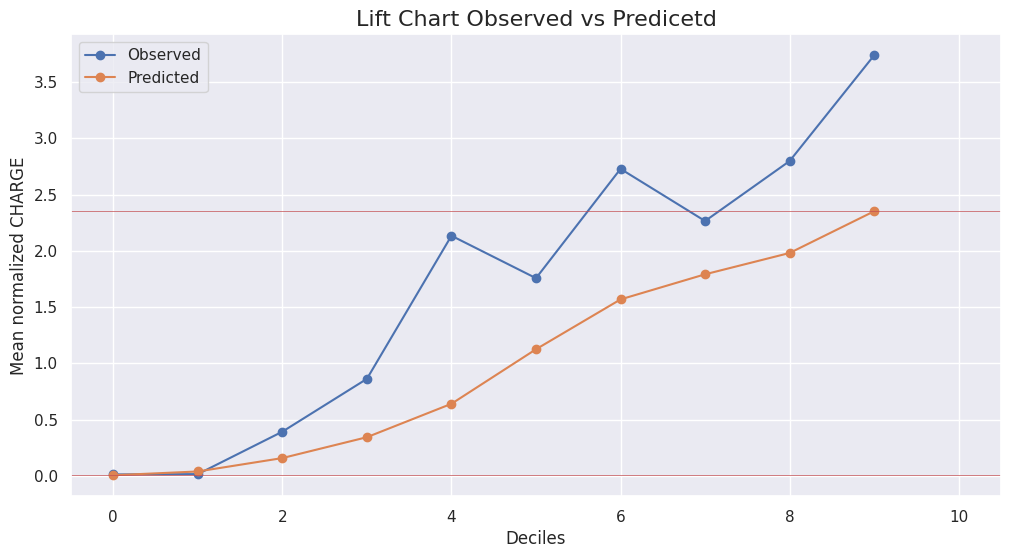

In [125]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, cb_tweedie_pred)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

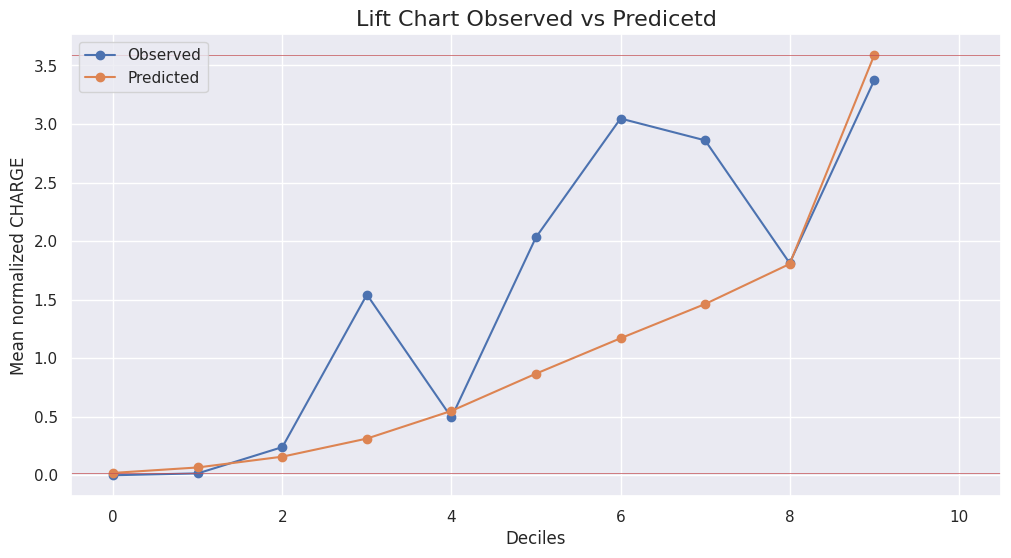

In [126]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_cb_rgr)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

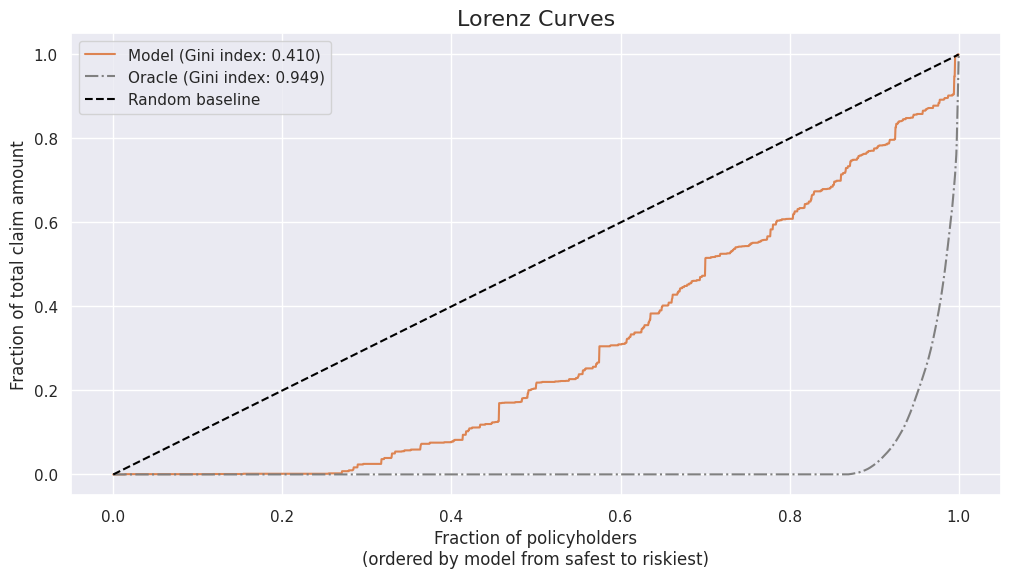

In [127]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, cb_tweedie_pred)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')

In [131]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100
EPOCHS=10000
NUM_TRIALS = 100

In [132]:
def objective(trial):
    params = {}
    params['loss_function'] = trial.suggest_categorical('loss_function', ['Tweedie'])
    params['eval_metric'] = trial.suggest_categorical('eval_metric', ['RMSE'])
    #params['n_estimators'] = trial.suggest_categorical('n_estimators', [10000]),
    params['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 0.02, log=True)
    params['depth'] = trial.suggest_int('depth', 9, 15)
    params['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5, log=True)
    params['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    params['grow_policy'] = trial.suggest_categorical('grow_policy', ['Depthwise'])
    params['iterations'] = trial.suggest_categorical('iterations', [10000])
    params['use_best_model'] = trial.suggest_categorical('use_best_model', [True])
    #params['eval_metric'] = trial.suggest_categorical('eval_metric', ['RMSE'])
    params['od_type'] = trial.suggest_categorical('od_type', ['Iter'])
    params['od_wait'] = trial.suggest_categorical('od_wait', [20])
    params['random_state'] = trial.suggest_categorical('random_state', [RANDOM_SEED])
    params['logging_level'] = trial.suggest_categorical('logging_level', ['Silent'])
    params['boosting_type']: trial.suggest_categorical("boosting_type", ["Ordered", "Plain"])


    #Tweedie needs variance power
    if params['loss_function'] == 'Tweedie':
        params['loss_function'] = 'Tweedie:variance_power=' + str(trial.suggest_float('loss_function_tweedie', 1, 2))
    #if params['eval_metric'] == 'Tweedie':
    #    params['eval_metric'] = 'Tweedie:variance_power=' + str(trial.suggest_float('eval_metric_tweedie', 1, 2))


    ## CREATE catboost model
    model = CatBoostRegressor(**params
                              #,iterations=EPOCHS
                              )
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=EARLY_STOPPING_ROUND,
        verbose=0,
        use_best_model=True,
        )
    y_pred = model.predict(X_val)
    loss = mean_squared_error(y_val, y_pred, squared=False)
    return loss

In [133]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
#study.optimize(objective, n_trials=NUM_TRIALS, n_jobs=-1) #, timeout=24000)
study.optimize(objective, n_trials=NUM_TRIALS, n_jobs=-1) #, timeout=24000)

[I 2023-10-26 11:48:00,852] A new study created in memory with name: catboost-seed1
[I 2023-10-26 11:48:16,044] Trial 152 finished with value: 1483.1183567951618 and parameters: {'loss_function': 'Tweedie', 'eval_metric': 'RMSE', 'learning_rate': 0.0011414777378319866, 'depth': 9, 'l2_leaf_reg': 2.43807285404522, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'iterations': 10000, 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 20, 'random_state': 1, 'logging_level': 'Silent', 'loss_function_tweedie': 1.4351490952259984}. Best is trial 150 with value: 1482.5067783973195.
[I 2023-10-26 11:48:42,256] Trial 6 finished with value: 1494.4956437366598 and parameters: {'loss_function': 'Tweedie', 'eval_metric': 'RMSE', 'learning_rate': 0.011520580515752273, 'depth': 9, 'l2_leaf_reg': 1.1581051557637942, 'min_child_samples': 1, 'grow_policy': 'Depthwise', 'iterations': 10000, 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 20, 'random_state': 1, 'logging_level': 'Silent', 'los

CPU times: user 1h 9min 47s, sys: 5min 26s, total: 1h 15min 14s
Wall time: 9min 55s


In [143]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
hp_cb = study.best_params

# Print the objective value and the set of hyperparameters of the best trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 1482.0563010426933
  Params: 
    loss_function: Tweedie
    eval_metric: RMSE
    learning_rate: 0.009356677360646078
    depth: 9
    l2_leaf_reg: 1.9475480403626986
    min_child_samples: 32
    grow_policy: Depthwise
    iterations: 10000
    use_best_model: True
    od_type: Iter
    od_wait: 20
    random_state: 1
    logging_level: Silent
    loss_function_tweedie: 1.3698998460520853


In [144]:
if (hp_cb['loss_function']=='Tweedie'):
  hp_cb['loss_function'] = 'Tweedie:variance_power='+str(hp_cb['loss_function_tweedie'])
  hp_cb.pop('loss_function_tweedie', None)

In [145]:
hp_cb

{'loss_function': 'Tweedie:variance_power=1.3698998460520853',
 'eval_metric': 'RMSE',
 'learning_rate': 0.009356677360646078,
 'depth': 9,
 'l2_leaf_reg': 1.9475480403626986,
 'min_child_samples': 32,
 'grow_policy': 'Depthwise',
 'iterations': 10000,
 'use_best_model': True,
 'od_type': 'Iter',
 'od_wait': 20,
 'random_state': 1,
 'logging_level': 'Silent'}

In [146]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image("./ActuarialThesis/plots_rgr/myCatBoostRegressorParamImportances.pdf")
fig.show()

In [147]:
optimized_cb_rgr = CatBoostRegressor(**hp_cb)
optimized_cb_rgr.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     early_stopping_rounds=EARLY_STOPPING_ROUND,
                     verbose=False,
                     );

In [148]:
y_pred_cb_rgr = optimized_cb_rgr.predict(X_test)
print("Best rmse:", mean_squared_error(y_pred_cb_rgr, y_test, squared=False))
print("R2 using CatBoost: ", r2_score(y_test, y_pred_cb_rgr ))

Best rmse: 1329.557525469574
R2 using CatBoost:  0.010374046160420924


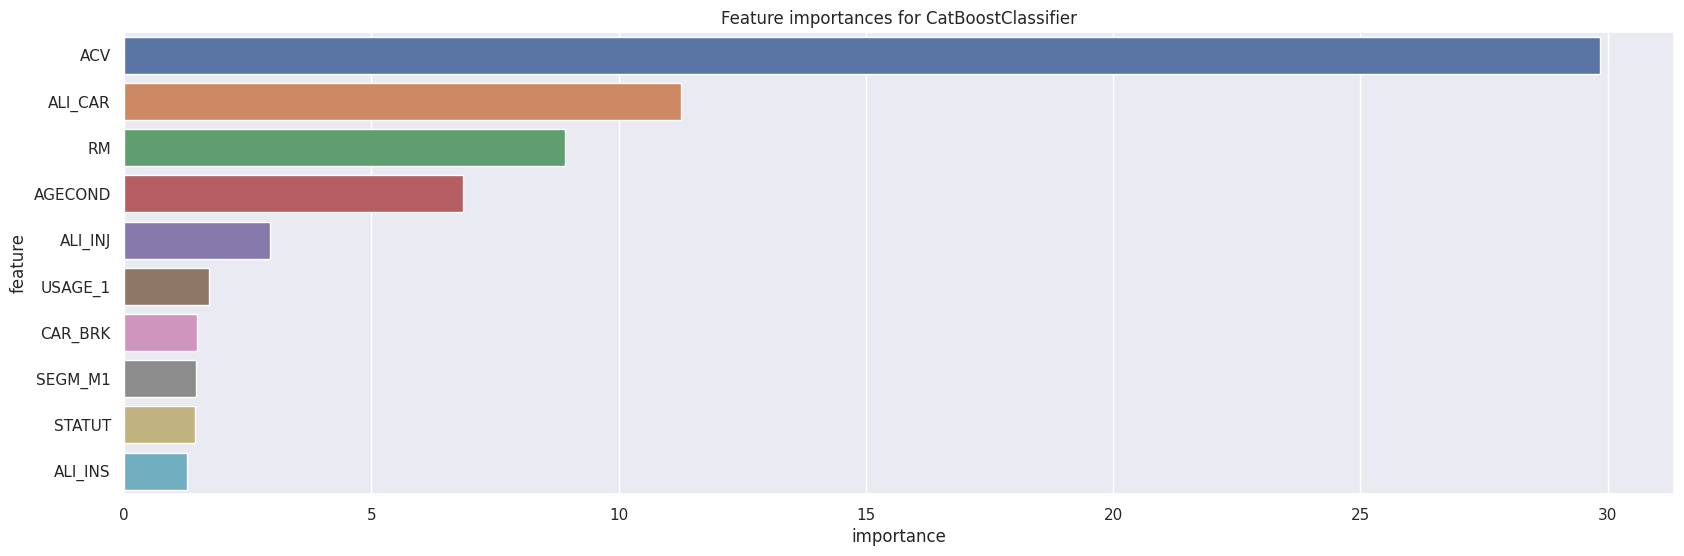

In [149]:
feature_importances = zip(X_train.columns, optimized_cb_rgr.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

fig = plt.gcf()
fig.figure.set_size_inches(20, 6)
plt.title('Feature importances for CatBoostClassifier')
sns.barplot(x='importance', y='feature', data=feature_importances[:10])
plt.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorFeatureImportance.pdf')

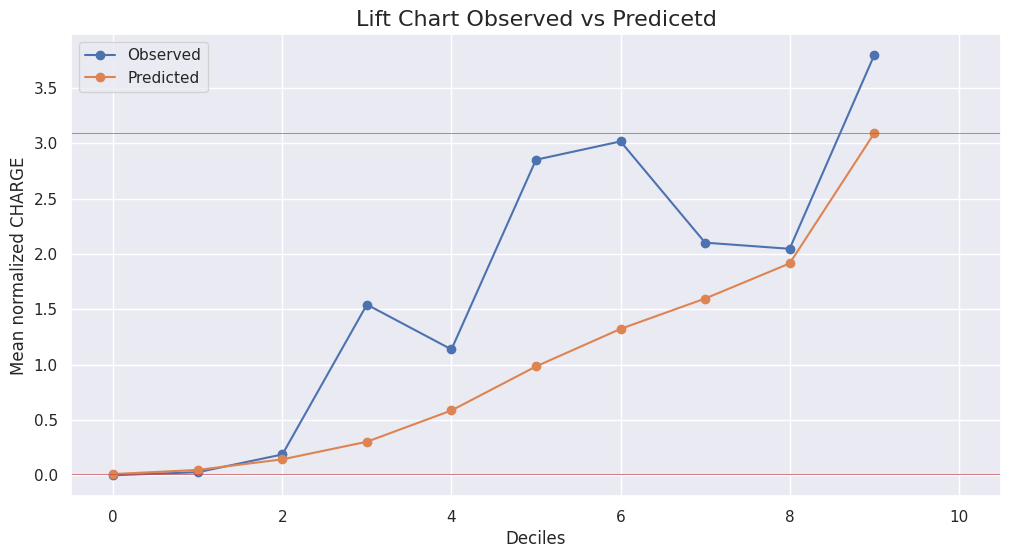

In [150]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_cb_rgr)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

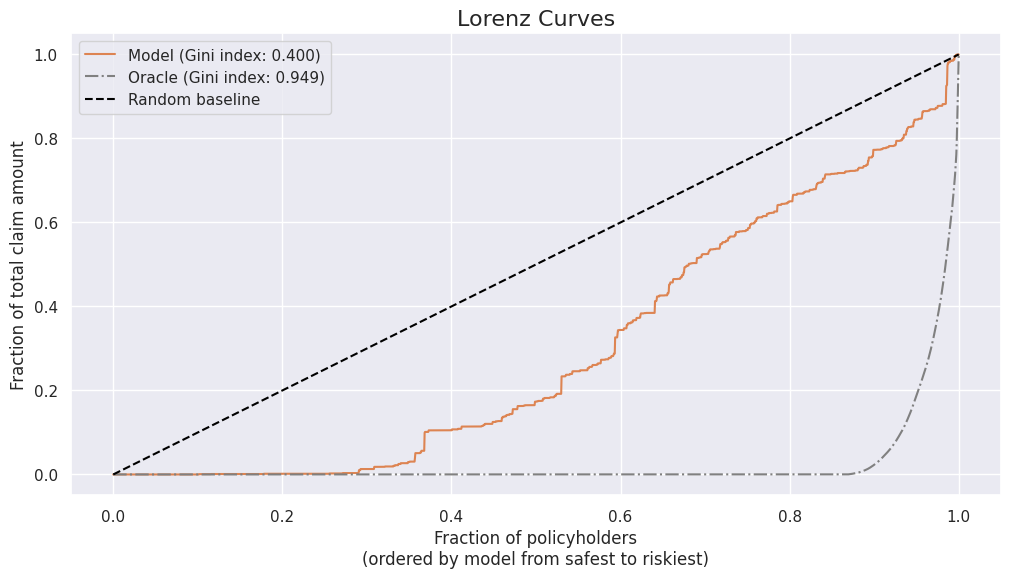

In [151]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_cb_rgr)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')

In [90]:
np.mean(y_test), np.mean(y_pred_cb_rgr)

(248.89134570311523, 161.44193164699692)

In [91]:
np.std(y_test), np.std(y_pred_cb_rgr)

(1336.5080972003657, 308.5801625155471)